In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Flatten, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model

In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32')  / 255.

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test  = x_test.reshape((x_test.shape[0], 28, 28, 1))

#dkl_train = np.concatenate((np.zeros((x_train.shape[0], 1)), np.ones((x_train.shape[0], 1))), axis=1)
#dkl_test  = np.concatenate((np.zeros((x_test.shape[0], 1)), np.ones((x_test.shape[0], 1))), axis=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [3]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [4]:
# Model
in_img = Input(shape=(28, 28, 1), name='INPUT1')

h1 = Conv2D(32, (3, 3), activation='relu', padding='same')(in_img)
h1 = MaxPooling2D()(h1)
h1 = Conv2D(16, (3, 3), activation='relu', padding='same')(h1)
h1 = MaxPooling2D()(h1)
h1 = Flatten(name='H1')(h1)

in_lab = Input(shape=(10,), name='INPUT2')
h2 = Dense(16, activation='relu')(in_lab)
h2 = Dense(32, activation='relu', name='H2')(h2)

latent = Concatenate(axis=1, name='LATENT_A')([h1, h2])
latent = Dense(784, activation='relu', name='LATENT_B')(latent)

h1 = Reshape((7, 7, 16), name='LAT2H1')(latent)
h1 = Conv2D(16, (3, 3), activation='relu', padding='same')(h1)
h1 = UpSampling2D()(h1)
h1 = Conv2D(32, (3, 3), activation='relu', padding='same')(h1)
h1 = UpSampling2D()(h1)
out_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='OUT1')(h1)

h2 = Dense(32, activation='relu')(latent)
h2 = Dense(16, activation='relu')(h2)
out_lab = Dense(10, activation='softmax', name='OUT2')(h2)

siamese = Model([in_img, in_lab], [out_img, out_lab])
siamese.summary()

siamese.compile(optimizer='adam', loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT1 (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         INPUT1[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 16)   4624        max_pooling2d[0][0]              
______________________________________________________________________________________________

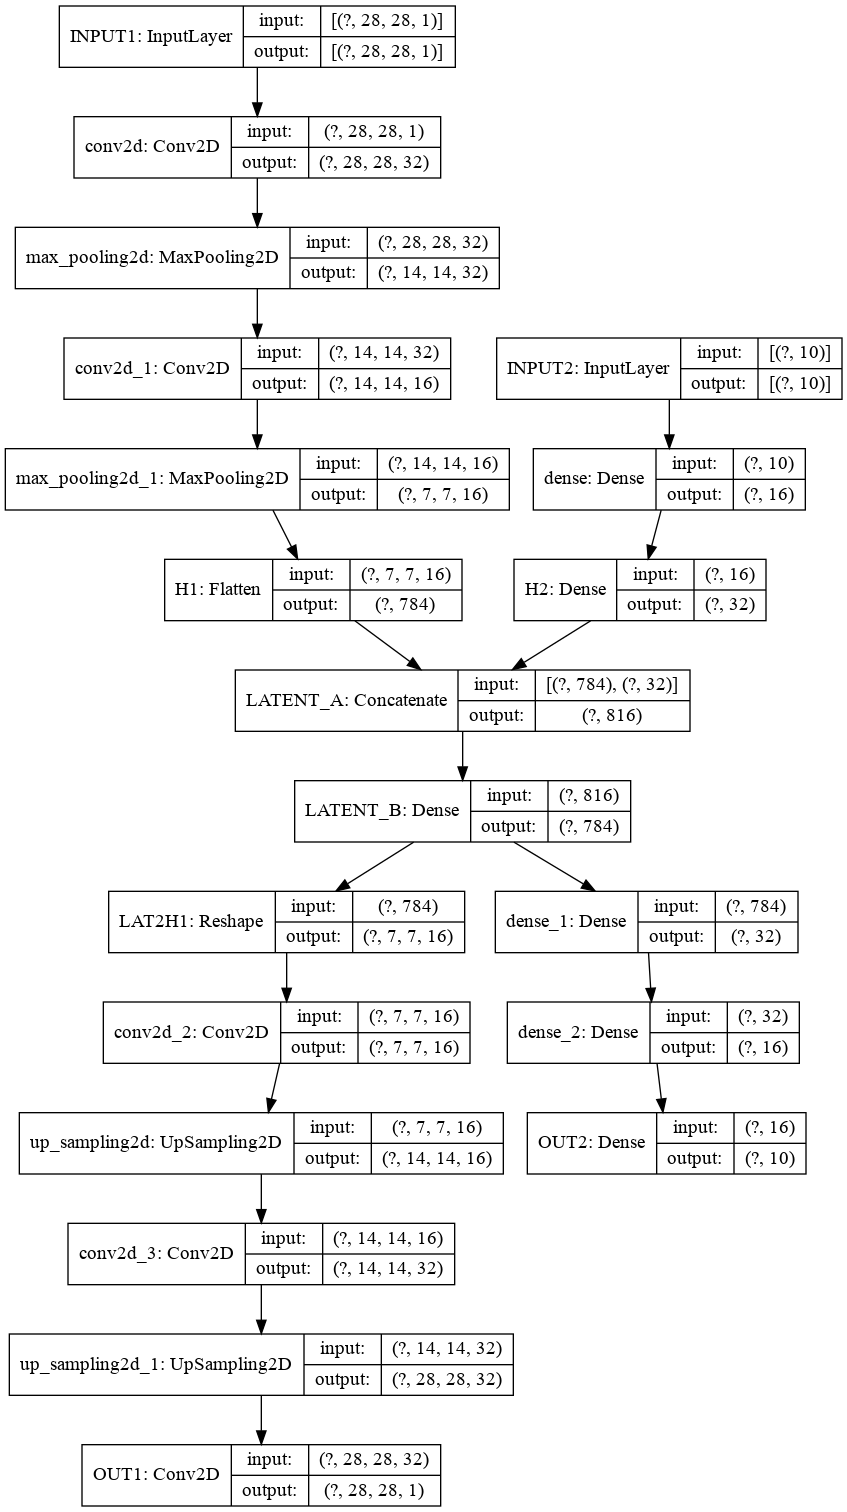

In [5]:
# Plot model
plot_model(siamese, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [6]:
# Compile and train
history = siamese.fit([x_train, y_train], [x_train, y_train], epochs=2, batch_size=128, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 68s 1ms/sample - loss: 0.3016 - OUT1_loss: 0.1141 - OUT2_loss: 0.1875 - OUT1_accuracy: 0.8083 - OUT2_accuracy: 0.9422 - val_loss: 0.1135 - val_OUT1_loss: 0.1110 - val_OUT2_loss: 0.0025 - val_OUT1_accuracy: 0.8093 - val_OUT2_accuracy: 0.9997
Epoch 2/2
48000/48000 [==============================] - 71s 1ms/sample - loss: 0.1128 - OUT1_loss: 0.1122 - OUT2_loss: 5.4636e-04 - OUT1_accuracy: 0.8087 - OUT2_accuracy: 1.0000 - val_loss: 0.1114 - val_OUT1_loss: 0.1110 - val_OUT2_loss: 4.0455e-04 - val_OUT1_accuracy: 0.8093 - val_OUT2_accuracy: 0.9999
